**Description**: Demonstrate that an arbitrary out-of-sample precision can be achieved
simply by reducing the frequency of positive observations going from in-sample to
out-of-sample data. The analysis reveals a useful workflow:

1. To identify the problem, simply track the average production label. If there's
   evidence that this is going down, then estimate the precision in production by
   labeling >=200 observations which were predicted to be positive. Expect this estimate
   to be lower than the one you computed on in-sample data.
2. Estimate the new proportion of positives in production using
   `estimate_frac_positives_out_sample`.
3. To fix the problem, a simple/temporary fix is to adjust predictions using the
   ratio of proportions of positives in production vs. in-sample. This fix is
   implemented in `predict_proba_adjusted`.

**Estimated runtime**: 10 sec.

**Package requirements**:
```
matplotlib==3.4.3
scikit-learn==0.24.2
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import ClassifierMixin
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Input parameters

By default, in-sample precision is ~0.95. The desired precision should be less than
that, since the notebook drops positives. If we want greater precision, we'd have to
drop negatives.

In [2]:
desired_precision_out_sample = 0.60
assert desired_precision_out_sample < 0.95

Hypothesis: assuming a model is calibrated-in-the-large, then precision decreases
but recall stays the same on out-of-sample data w/ fewer positives than in-sample data.

# Prepare data in-sample

In [3]:
X, y = make_classification(
    n_samples=100_000,
    n_classes=2,
    n_features=5,
    n_informative=5,
    n_redundant=0,
    random_state=123,
)

In [4]:
# split into in and out-of-sample data. we'll make out-of-sample data unbalanced
_X_in_sample, _X_out_sample, _y_in_sample, _y_out_sample = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# split in-sample data into training and test. both balanced
X_tr, X_te, y_tr, y_te = train_test_split(
    _X_in_sample, _y_in_sample, test_size=0.2, random_state=42
)

In [5]:
# in-sample data is balanced
print(y_tr.mean())
print(y_te.mean())

0.4983125
0.50275


# Fit

We'll fit a logistic regression b/c we know it's calibrated-in-the-large.

In [6]:
model = LogisticRegression().fit(X_tr, y_tr)
assert model.score(X_tr, y_tr) > 0.6, "really bad fit"

# Gather metrics in-sample

In [7]:
def metrics(y_true: np.ndarray, y_pred: np.ndarray):
    # input checks
    _binary_array = np.array([0, 1])
    if not np.all(np.unique(y_true) == _binary_array):
        raise ValueError("y_true must only contain 0s and 1s.")
    if not np.all(np.unique(y_pred) == _binary_array):
        raise ValueError("y_pred must only contain 0s and 1s.")

    metric_to_value = dict()
    # marginal scores
    metric_to_value["frac_positive"] = y_true.sum() / len(y_true)
    metric_to_value["frac_positive_pred"] = y_pred.sum() / len(y_pred)
    # conditional scores
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metric_to_value["precision"] = tp / (tp + fp)
    metric_to_value["recall"] = tp / (tp + fn)
    metric_to_value["specificity"] = tn / (tn + fp)

    return metric_to_value

In [8]:
metrics_in_sample = metrics(y_te, model.predict(X_te))

In [9]:
metrics_in_sample

{'frac_positive': 0.50275,
 'frac_positive_pred': 0.4955,
 'precision': 0.9513118062563067,
 'recall': 0.9375932371954252,
 'specificity': 0.9514831573655103}

# Prepare data out-of-sample

Let $P$ be the distribution from our in-sample data was sampled, and $Q$ be that for
out-of-sample data. The only fundamental difference between $P$ and $Q$ is that the
latter has fewer positive observations.

Assume a model was fit on a sample from $P$. Assume the model is
calibrated-in-the-large, i.e., $P(Y = 1) = P(\hat{Y} = 1)$. We need a way to calculate
$q = Q(Y = 1)$ so that it results in a given precision on $Q$. It's safe to assume that
recall and specificity are equivalent across $P$ and $Q$, because these metrics are
conditional on the class.

Apply Bayes' rule to the precision on $Q$:

$$
\begin{align*}
Q(Y = 1 \: | \: \hat{Y} = 1) &= Q(\hat{Y} = 1 \: | \: Y = 1) \frac{Q(Y = 1)}{ Q(\hat{Y}
= 1)} \\
Q(Y = 1 \: | \: \hat{Y} = 1) &= P(\hat{Y} = 1 \: | \: Y = 1) \frac{Q(Y = 1)}{Q(\hat{Y} =
1)} \\
Q(Y = 1) &= \frac{Q(Y = 1 \: | \: \hat{Y} = 1)}{P(\hat{Y} = 1 \: | \: Y = 1)} Q(\hat{Y}
= 1) \\
q &= \frac{Q_{\text{precision}}}{P_{\text{recall}}} Q(\hat{Y} = 1) \\
&= r Q(\hat{Y} = 1).
\end{align*}
$$

Apply the law of total probability to break down $Q(\hat{Y} = 1)$:

$$
\begin{align*}
Q(\hat{Y} = 1) &= Q(\hat{Y} = 1 \: | \: Y = 1)q + Q(\hat{Y} = 1 \: | \: Y = 0)(1-q) \\
&= P(\hat{Y} = 1 \: | \: Y = 1)q + P(\hat{Y} = 1 \: | \: Y = 0)(1-q) \\
&= P_{\text{recall}}q + (1 - P_{\text{specificity}})(1-q).
\end{align*}
$$

Plugging it in to the first equation for $q$, we can now solve for $q$. First let $r = 

$$
\begin{align*}
q &= r \cdot \big( P_{\text{recall}}q + (1 - P_{\text{specificity}})(1-q) \big) \\
q &= r \cdot \big( P_{\text{recall}}q + (1 - P_{\text{specificity}}) - (1 -
P_{\text{specificity}})q \big) \\
q - r P_{\text{recall}}q + r(1 - P_{\text{specificity}})q &= r \cdot \big( 1 -
P_{\text{specificity}} \big) \\
q &= \frac{r \cdot \big( 1 - P_{\text{specificity}} \big)}{1 - r P_{\text{recall}} + r
\cdot \big( 1 - P_{\text{specificity}} \big)}
\end{align*}
$$

So we can calculate the fraction of positives in $Q$ given in-sample recall and
precision, and given out-of-sampe precision (it's the numerator of the ratio $r$).

In [10]:
def estimate_frac_positives_out_sample(
    out_sample_precision: float, in_sample_recall: float, in_sample_specificity: float
):
    _r = out_sample_precision / in_sample_recall
    _numerator = _r * (1 - in_sample_specificity)
    return _numerator / (1 - _r * in_sample_recall + _numerator)

In [11]:
_q = estimate_frac_positives_out_sample(
    desired_precision_out_sample,
    metrics_in_sample["recall"],
    metrics_in_sample["specificity"],
)

# calculate the drop_probability needed to achieve q
_n_pos = _y_out_sample.sum()
_n_neg = len(_y_out_sample) - _n_pos
drop_probability = 1 - ((_q * _n_neg) / (_n_pos - _q * _n_pos))
drop_probability

0.9233833047565825

In [12]:
# make out-of-sample data unbalanced, dropping positives
# recall hypothesis from math: dropping positives causes precision to decrease

mask_positive = _y_out_sample == 1
mask = ~mask_positive
mask_random = np.random.choice(
    [True, False], size=mask_positive.sum(), p=[1 - drop_probability, drop_probability]
)
mask[mask_positive] = mask_random

# no negative labels dropped
assert (_y_out_sample[mask] == 0).sum() == (_y_out_sample == 0).sum()

# some positive labels dropped
assert _y_out_sample[mask].sum() < _y_out_sample.sum()

# apply mask to simulate out-of-sample data, which isn't balanced
X_out_sample = _X_out_sample[mask]
y_out_sample = _y_out_sample[mask]

# Gather metrics out-of-sample

First, recall in-sample metrics:

In [13]:
metrics_in_sample

{'frac_positive': 0.50275,
 'frac_positive_pred': 0.4955,
 'precision': 0.9513118062563067,
 'recall': 0.9375932371954252,
 'specificity': 0.9514831573655103}

Here are out-of-sample metrics:

In [14]:
metrics_out_sample = metrics(y_out_sample, model.predict(X_out_sample))
metrics_out_sample

{'frac_positive': 0.07149532710280374,
 'frac_positive_pred': 0.11700934579439252,
 'precision': 0.5814696485623003,
 'recall': 0.9516339869281045,
 'specificity': 0.9472571716155007}

We didn't hit 60% precision exactly. The sources of error are that we used in-sample
recall to estimate out-of-sample recall and specificty. Methinks it's close enough.
Hypothesis confirmed.

# A simple fix

Probabilities from in-sample data (where we trained) are:

$$
\begin{align*}
y_P &= P(Y = 1 \: | \: x) \\
&= \frac{P(x \: | \: Y = 1) p}{P(x)} \\
&= \frac{P(x \: | \: Y = 1) p}{P(x \: | \: Y = 1) p + P(x \: | \: Y = 0) (1-p)}
\end{align*}
$$

On out-of-sample data, they should be:

$$
\begin{align*}
y_Q &= Q(Y = 1 \: | \: x) \\
&= \frac{Q(x \: | \: Y = 1) q}{Q(x \: | \: Y = 1) q + Q(x \: | \: Y = 0) (1-q)} \\
&= \frac{P(x \: | \: Y = 1) q}{P(x \: | \: Y = 1) q + P(x \: | \: Y = 0) (1-q)}
\end{align*}
$$

Using the facts that

$$
\begin{align*}
P(x \: | \: Y = 1) &= \frac{P(Y = 1 \: | \: x) P(x)}{p} \\
&= P(x) \frac{y_P}{p}
\end{align*}
$$

and

$$
\begin{align*}
P(x \: | \: Y = 0) &= \frac{P(Y = 0 \: | \: x) P(x)}{1 - p} \\
&= P(x) \frac{1 - y_P}{1 - p}
\end{align*}
$$

we can express $y_Q$ purely as a function of $y_P, p, q$:

$$
\begin{align*}
y_Q &= \frac{P(x) \frac{y_P}{p} q}{P(x) \frac{y_P}{p} q + P(x) \frac{1-y_P}{1-p}(1-q)}
\\
&= \frac{P(x) y_P \cdot \frac{q}{p}}{P(x) \bigg( y_P \cdot \frac{q}{p} + (1 - y_P) \cdot
\frac{1-q}{1-p} \bigg)} \\
&= \frac{y_P \cdot \frac{q}{p}}{y_P \cdot \frac{q}{p} + (1 - y_P) \cdot
\frac{1-q}{1-p}}
\end{align*}
$$

In other words, if the only difference b/t $P$ and $Q$ is the frequency of positives, we
can "re-calibrate" predictions from $P$ so that they work for $Q$.

We need to estimate the fraction of positives in out-of-sample data.

Say we computed out-of-sample precision by *only labeling positive predictions (from
production)* for correctness, i.e., we never looked at negative predictions. We can
still estimate the fraction of positives in out-of-sample data by using the formula in
`estimate_frac_positives_out_sample`.

In [15]:
(X_out_sample_tr, X_out_sample_te, y_out_sample_tr, y_out_sample_te) = train_test_split(
    X_out_sample, y_out_sample, test_size=0.5, random_state=53
)

In [16]:
out_sample_precision_est = precision_score(
    y_out_sample_tr, model.predict(X_out_sample_tr)
)

frac_positive_out_sample_est = estimate_frac_positives_out_sample(
    out_sample_precision_est,
    metrics_in_sample["recall"],
    metrics_in_sample["specificity"],
)

In [17]:
def predict_proba_adjusted(
    model: ClassifierMixin,
    X: np.ndarray,
    frac_positive_out_sample_est: float,
    frac_positive_in_sample_est: float,
) -> np.ndarray:
    pred_probs_out_sample_te = model.predict_proba(X)[:, 1]

    _numerator = pred_probs_out_sample_te * (
        frac_positive_out_sample_est / frac_positive_in_sample_est
    )
    _denominator = _numerator + (
        (1 - pred_probs_out_sample_te)
        * ((1 - frac_positive_out_sample_est) / (1 - frac_positive_in_sample_est))
    )
    return _numerator / _denominator

In [18]:
pred_probs_out_sample_te_adjusted = predict_proba_adjusted(
    model,
    X_out_sample_te,
    frac_positive_out_sample_est,
    metrics_in_sample["frac_positive"],
)

In [19]:
metrics(y_out_sample_te, pred_probs_out_sample_te_adjusted > 0.5)

{'frac_positive': 0.07177570093457944,
 'frac_positive_pred': 0.0605607476635514,
 'precision': 0.9259259259259259,
 'recall': 0.78125,
 'specificity': 0.9951671365283931}

Retraining is probably better. For logistic regression, you'd just have to adjust the
intercept (there should be a formula for that). TBH idk why this adjustment method
didn't work *great*. But it's simple and easy to deploy. It's fine as a temporary
measure.

Mess w/ threshold too:

In [20]:
metrics(y_out_sample_te, pred_probs_out_sample_te_adjusted > 0.3)

{'frac_positive': 0.07177570093457944,
 'frac_positive_pred': 0.07121495327102803,
 'precision': 0.868766404199475,
 'recall': 0.8619791666666666,
 'specificity': 0.9899315344341523}

I'm curious about calibration.

In [21]:
def plot_calibration_curve(y, pred_probs, n_bins=5, title=""):
    # gather statistics
    prob_true, prob_pred = calibration_curve(y, pred_probs, n_bins=n_bins)
    bins = np.linspace(0, 1, n_bins+1)
    bin_inds = np.digitize(pred_probs, bins) - 1
    bin_sizes = np.bincount(bin_inds)
    y_std_err = np.sqrt(prob_true*(1 - prob_true) / bin_sizes)

    # plot curve
    plt.errorbar(prob_pred, prob_true, yerr=2*y_std_err, 
                 label='Model w/ 95% CI',
                 capsize=5, marker='o', linestyle='dashed')
    plt.plot([0, 1], [0, 1], label='Perfect calibration')
    plt.legend()
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed fraction")
    plt.title(title)

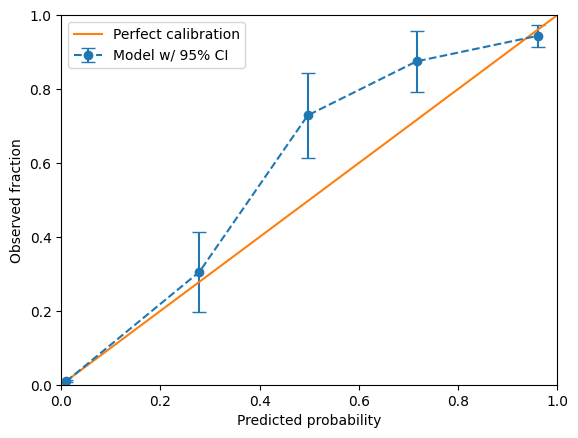

In [22]:
plot_calibration_curve(y_out_sample_te, pred_probs_out_sample_te_adjusted)

The adjustment is an underestimator for some reason. If we had a labeled dataset which
includes positives and negatives, we could instead fit a logistic regression on top of
the original model's predicted probabilities. Let's see how that compares.

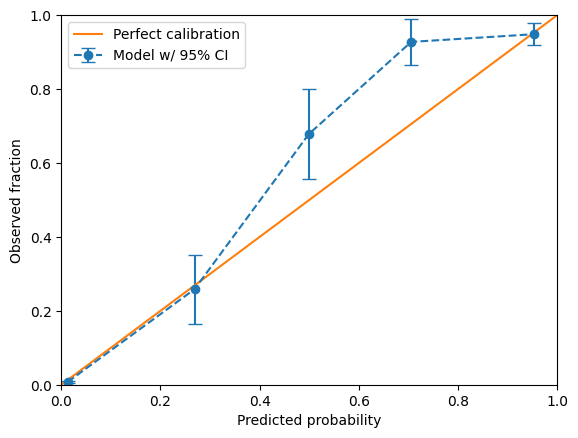

In [23]:
recalibrator = CalibratedClassifierCV(estimator=model).fit(
    X_out_sample_tr, y_out_sample_tr
)
plot_calibration_curve(
    y_out_sample_te,
    recalibrator.predict_proba(X_out_sample_te)[:, 1],
)

Not significantly better than the adjustment rule for this particular `model`.